# Table of Contents
 <p><div class="lev1 toc-item"><a href="#ニューラルネットワークの学習" data-toc-modified-id="ニューラルネットワークの学習-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>ニューラルネットワークの学習</a></div><div class="lev2 toc-item"><a href="#勾配" data-toc-modified-id="勾配-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>勾配</a></div><div class="lev1 toc-item"><a href="#ニューラルネットワークに対する勾配" data-toc-modified-id="ニューラルネットワークに対する勾配-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>ニューラルネットワークに対する勾配</a></div><div class="lev1 toc-item"><a href="#学習アルゴリズムの実装" data-toc-modified-id="学習アルゴリズムの実装-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>学習アルゴリズムの実装</a></div>

# ニューラルネットワークの学習

ニューラルネットワークによる分類問題では中間行列の要素さえ正しく選べばいいことはわかったよね．で，それをどうするかがここ．

損失関数という指標を決めて，数値微分で求めた勾配の安定性を用いて，指標が最小となるパラメータを決めるだけ．．．それだけ．．．

* 損失関数(loss function)
  * 2乗和誤差
  * 交差エントロピー誤差
* ミニバッチ学習
* 数値微分
* 勾配法(gradient method)

  

## 勾配

数値計算で勾配を求める．行列のそれぞれの要素に対して，損失関数＄L$に対しての偏微分を数値的に求める．

$$
\begin{aligned}
x_0 &= x_0 - \eta \frac{\partial f}{\partial x_0} \\
x_1 &= x_1 - \eta \frac{\partial f}{\partial x_1} \\
\end{aligned}
$$

# ニューラルネットワークに対する勾配

In [1]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
from common.functions import softmax, cross_entropy_error
from common.gradient import numerical_gradient

class simpleNet:
    def __init__(self):
        self.W = np.random.randn(2,3)
        
    def predict(self, x):
        return np.dot(x, self.W)
    
    def loss(self, x, t):
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entropy_error(y, t)
        
        return loss
    
net = simpleNet()
print(net.W)

[[ 1.10982867  0.08409845  0.38208287]
 [-1.31960178  1.19815539 -0.99865956]]


In [2]:
x = np.array([0.6, 0.9])
p = net.predict(x)
print(p)

[-0.5217444   1.12879892 -0.66954388]


In [3]:
t = np.array([0,0,1])
net.loss(x, t)

2.1040013023910085

In [4]:
def f(W):
    return net.loss(x, t)

dW = numerical_gradient(f, net.W)
print(dW)

[[ 0.08483667  0.44198288 -0.52681955]
 [ 0.127255    0.66297432 -0.79022932]]


# 学習アルゴリズムの実装

In [9]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
from common.functions import *
from common.gradient import numerical_gradient


class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
    
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
        
    # x:入力データ, t:教師データ
    def loss(self, x, t):
        y = self.predict(x)
        
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x:入力データ, t:教師データ
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
 

In [10]:
net = TwoLayerNet(input_size=784, hidden_size=100, output_size=10)
net.params['W1'].shape

(784, 100)

In [24]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
from dataset.mnist import load_mnist
from ch04.two_layer_net import TwoLayerNet

# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 10000  # 繰り返しの回数を適宜設定する
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 勾配の計算
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    
    # パラメータの更新
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))



train acc, test acc | 0.0993, 0.1032
train acc, test acc | 0.7967, 0.802
train acc, test acc | 0.878983333333, 0.8827
train acc, test acc | 0.8996, 0.9021
train acc, test acc | 0.90825, 0.9131
train acc, test acc | 0.9141, 0.9171
train acc, test acc | 0.91905, 0.9218
train acc, test acc | 0.922883333333, 0.9244
train acc, test acc | 0.92715, 0.9276
train acc, test acc | 0.9306, 0.9319
train acc, test acc | 0.932983333333, 0.9339
train acc, test acc | 0.935416666667, 0.9352
train acc, test acc | 0.937966666667, 0.9389
train acc, test acc | 0.94115, 0.941
train acc, test acc | 0.942883333333, 0.9425
train acc, test acc | 0.945666666667, 0.9425
train acc, test acc | 0.946066666667, 0.9442


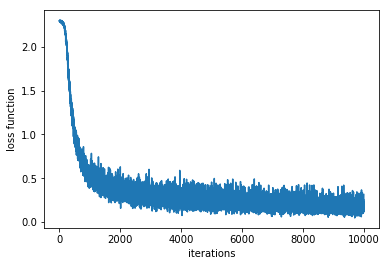

In [27]:
import matplotlib.pyplot as plt

# グラフの描画
markers = {'train': 'o'}
x = np.arange(len(train_loss_list))
plt.plot(x, train_loss_list, label='train loss')
plt.xlabel("iterations")
plt.ylabel("loss function")
plt.show()

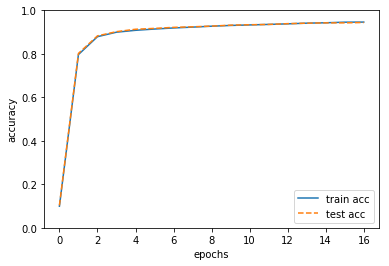

In [25]:
import matplotlib.pyplot as plt

# グラフの描画
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()